
Максимальная частота в спектре: 9.0 Гц
Минимальная частота дискретизации (Котельников): 18.0 Гц

Ширина спектра: 18.0 Гц
Объем памяти для хранения массива: 144 байт

Ширина спектра: (Fs = 72.0 Гц)
Объем памяти для хранения массива (Fs = 72.0 Гц): 576 байт

Частота дискретизации: 48000 Гц
Размер массива данных: 166552
Длительность звукозаписи: 1.7349166666666667 секунд
Прореженная частота дискретизации: 4800 Гц
Прореженный сигнал сохранен в файл: audio_downsampled.wav



<ipython-input-9-772dd62d6322>:92: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, audio_data = wavfile.read('audio.wav')


Средняя ошибка квантования (3 бит): 0.4609
Средняя ошибка квантования (4 бит): 0.4474
Средняя ошибка квантования (5 бит): 0.4408
Средняя ошибка квантования (6 бит): 0.4369


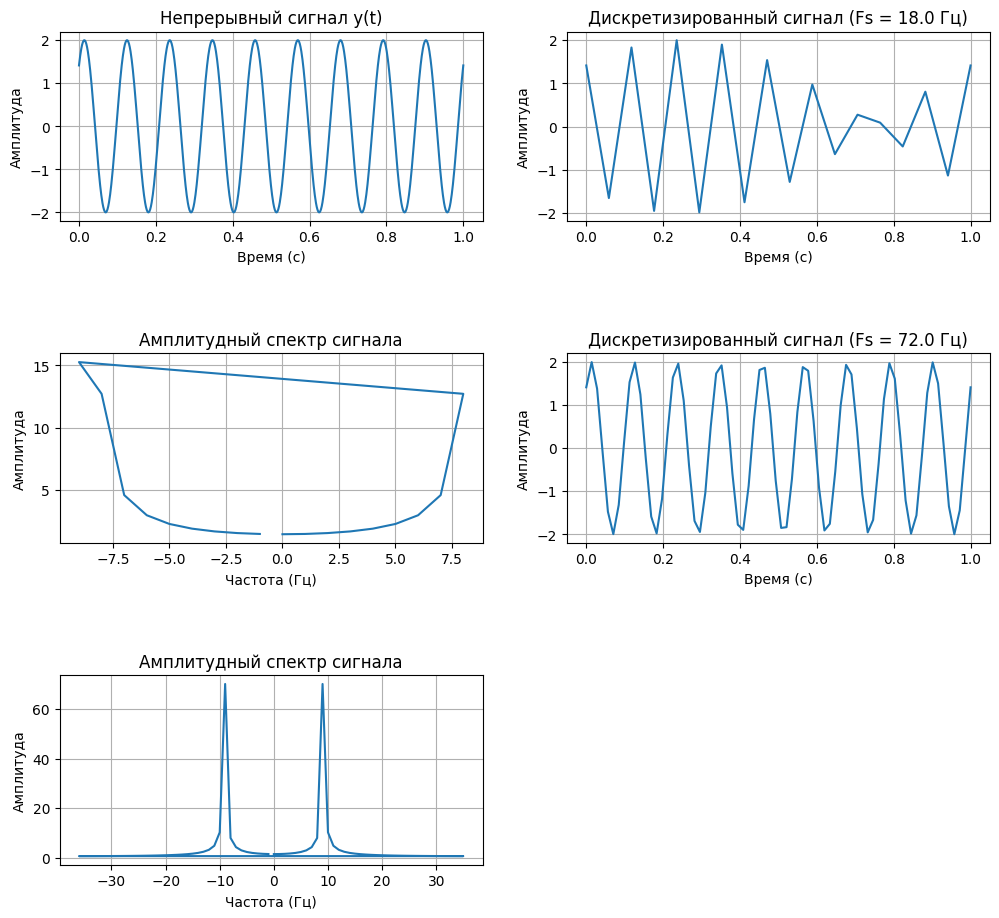

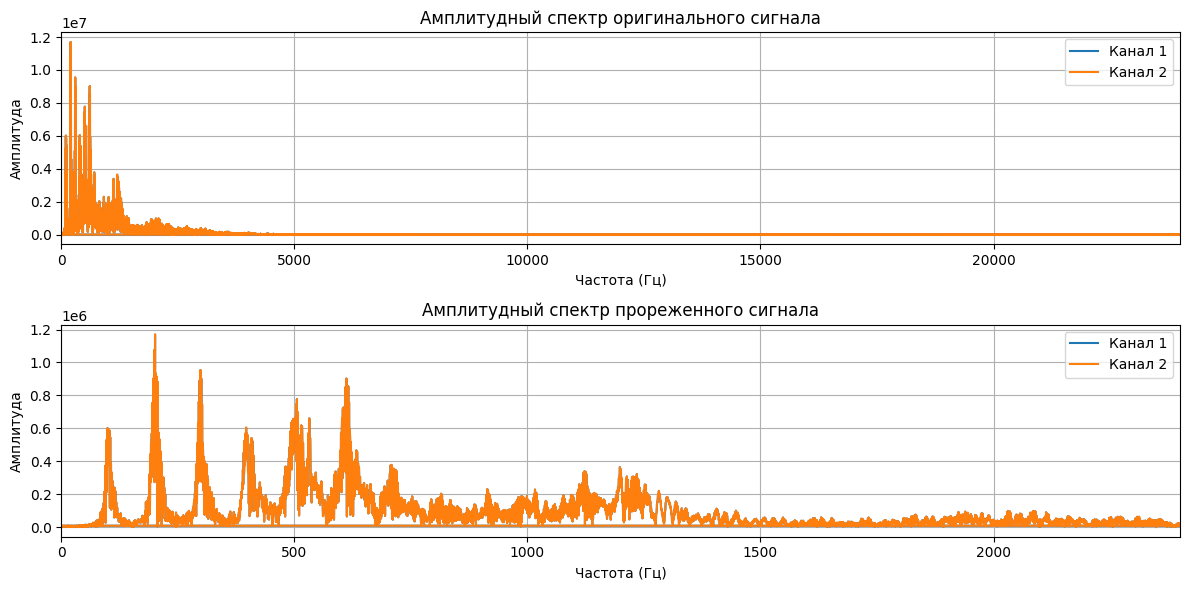

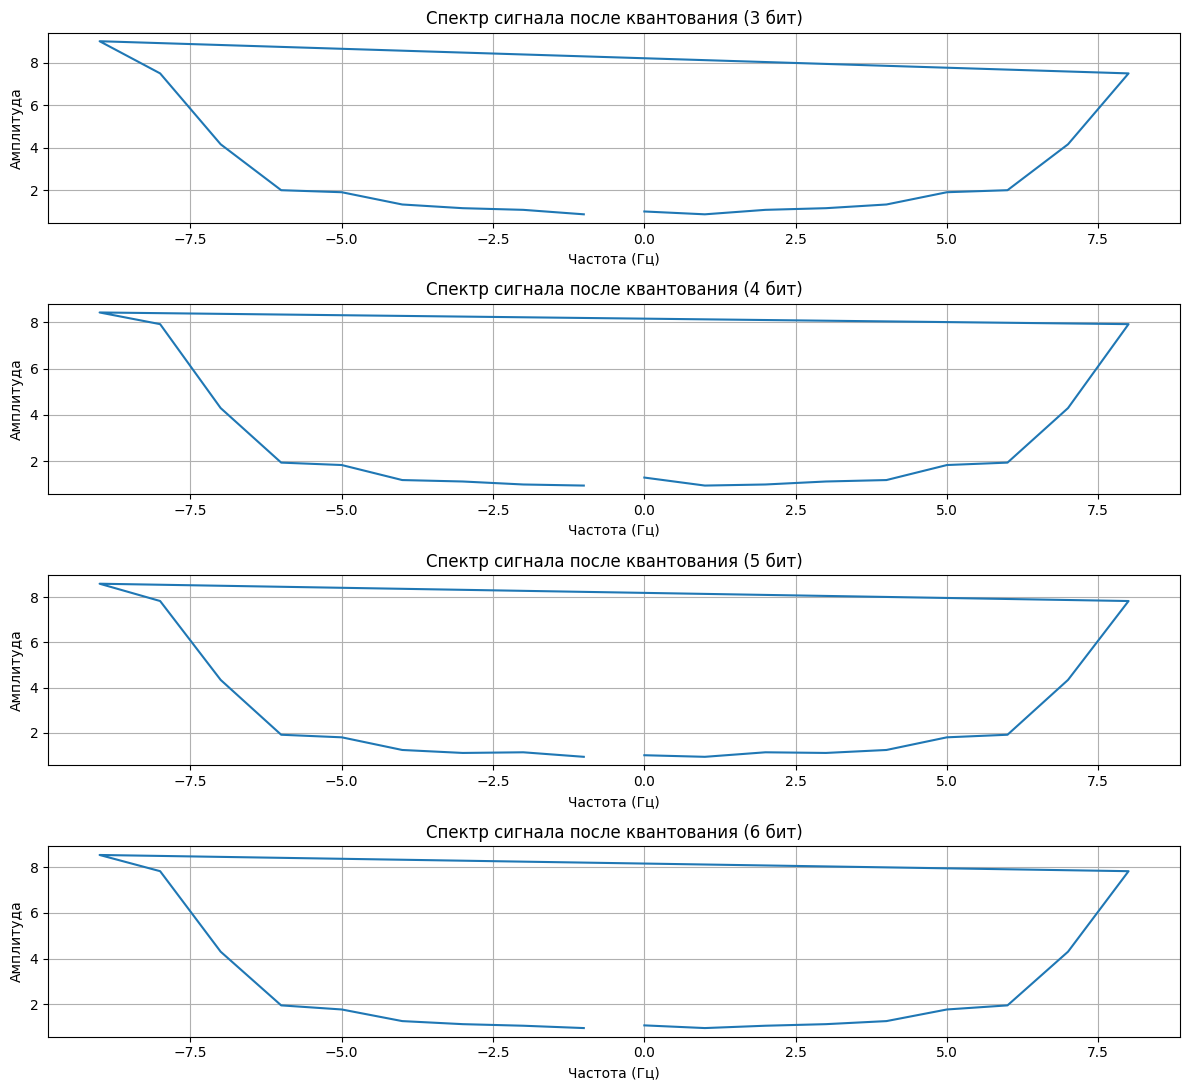

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.interpolate import interp1d
from scipy.signal import resample
import os


def generate_signal(f, t):
    return 2 * np.sin(2 * np.pi * f * t + np.pi/4)


def plot_signal(t, signal, title, subplot_pos):
    plt.subplot(subplot_pos)
    plt.plot(t, signal)
    plt.title(title)
    plt.xlabel("Время (с)")
    plt.ylabel("Амплитуда")
    plt.grid(True)


def calculate_max_frequency(signal, Fs):
    frequencies = np.fft.fftfreq(len(signal), 1/Fs)
    spectrum = np.abs(np.fft.fft(signal))
    max_frequency_index = np.argmax(spectrum)
    return abs(frequencies[max_frequency_index])


def discretize_signal(f, Fs, duration):
    num_samples = int(Fs * duration)
    time_points = np.linspace(0, duration, num_samples)
    discretize_signal = generate_signal(f, time_points)
    return time_points, discretize_signal


def plot_spectrum(signal, Fs, title="Амплитудный спектр сигнала", subplot_pos=None):
    frequencies = np.fft.fftfreq(signal.size, 1 / Fs)
    spectrum = np.abs(np.fft.fft(signal))

    if subplot_pos is not None:
        plt.subplot(subplot_pos)
    else:
        plt.figure(figsize=(12, 4))

    plt.plot(frequencies, spectrum)
    plt.title(title)
    plt.xlabel("Частота (Гц)")
    plt.ylabel("Амплитуда")
    plt.grid(True)


def quantize_signal(signal, num_bits):
    max_value = 2**(num_bits - 1) - 1
    quantized_signal = np.round(np.clip(signal * max_value, -max_value, max_value)) / max_value
    return quantized_signal


def main():
    f = 9
    duration = 1
    t1 = np.linspace(0, duration, 1000)
    continuous_signal = generate_signal(f, t1)

    plt.figure(figsize=(12, 15))
    plt.subplots_adjust(hspace=0.7)
    plot_signal(t1, continuous_signal, "Непрерывный сигнал y(t)", 421)

    Fs_temp = 1000
    max_frequency = calculate_max_frequency(generate_signal(f, np.linspace(0, duration, int(Fs_temp * duration))), Fs_temp)
    print(f"\nМаксимальная частота в спектре: {max_frequency} Гц")

    Fs_min = 2 * max_frequency
    print(f"Минимальная частота дискретизации (Котельников): {Fs_min} Гц")

    t2, discrete_signal = discretize_signal(f, Fs_min, duration)
    plot_signal(t2, discrete_signal, f"Дискретизированный сигнал (Fs = {Fs_min} Гц)", 422)

    plot_spectrum(discrete_signal, Fs_min, subplot_pos=423)
    spectral_width = Fs_min
    print(f"\nШирина спектра: {spectral_width} Гц")
    memory_usage = discrete_signal.nbytes
    print(f"Объем памяти для хранения массива: {memory_usage} байт")

    Fs_increased = 4 * Fs_min
    t3, discrete_signal_increased = discretize_signal(f, Fs_increased, duration)
    plot_signal(t3, discrete_signal_increased, f"Дискретизированный сигнал (Fs = {Fs_increased} Гц)", 424)
    plot_spectrum(discrete_signal_increased, Fs_increased, subplot_pos=425)
    print(f"\nШирина спектра: (Fs = {Fs_increased} Гц)")
    memory_usage_increased = discrete_signal_increased.nbytes
    print(f"Объем памяти для хранения массива (Fs = {Fs_increased} Гц): {memory_usage_increased} байт")

    Fs, audio_data = wavfile.read('audio.wav')
    print(f"\nЧастота дискретизации: {Fs} Гц")
    print(f"Размер массива данных: {audio_data.size}")
    duration_audio = len(audio_data) / Fs
    print(f"Длительность звукозаписи: {duration_audio} секунд")

    new_Fs = Fs // 10
    num_samples_new = int(len(audio_data) * (new_Fs / Fs))
    audio_data_downsampled = resample(audio_data, num_samples_new)
    print(f"Прореженная частота дискретизации: {new_Fs} Гц")
    output_filename = "audio_downsampled.wav"
    wavfile.write(output_filename, int(new_Fs), audio_data_downsampled.astype(np.int16))
    print(f"Прореженный сигнал сохранен в файл: {output_filename}\n")

    num_channels = audio_data.shape[1] if len(audio_data.shape) > 1 else 1
    plt.figure(figsize=(12, 6))
    plt.subplot(211)
    for channel in range(num_channels):
        spectrum_original = np.fft.fft(audio_data[:, channel] if num_channels > 1 else audio_data)
        amplitudes_original = np.abs(spectrum_original)
        frequencies_original = np.fft.fftfreq(audio_data.shape[0], 1/Fs)
        plt.plot(frequencies_original, amplitudes_original, label=f"Канал {channel+1}")

    plt.title('Амплитудный спектр оригинального сигнала')
    plt.xlabel('Частота (Гц)')
    plt.ylabel('Амплитуда')
    plt.xlim(0, Fs/2)
    plt.legend()
    plt.grid(True)

    num_channels_downsampled = audio_data_downsampled.shape[1] if len(audio_data_downsampled.shape) > 1 else 1
    plt.subplot(212)
    for channel in range(num_channels_downsampled):
        spectrum_downsampled = np.fft.fft(audio_data_downsampled[:, channel] if num_channels_downsampled > 1 else audio_data_downsampled)
        amplitudes_downsampled = np.abs(spectrum_downsampled)
        frequencies_downsampled = np.fft.fftfreq(audio_data_downsampled.shape[0], 1/new_Fs)
        plt.plot(frequencies_downsampled, amplitudes_downsampled, label=f"Канал {channel+1}")

    plt.title('Амплитудный спектр прореженного сигнала')
    plt.xlabel('Частота (Гц)')
    plt.ylabel('Амплитуда')
    plt.xlim(0, new_Fs/2)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    plt.figure(figsize=(12, 11))
    num_plots = len([3, 4, 5, 6])
    for i, num_bits in enumerate([3, 4, 5, 6], 1):
        quantized_signal = quantize_signal(discrete_signal, num_bits)
        plot_spectrum(quantized_signal, Fs_min, title=f"Спектр сигнала после квантования ({num_bits} бит)",
                     subplot_pos=num_plots * 100 + 10 + i)
        quantization_error = np.mean(np.abs(discrete_signal - quantized_signal))
        print(f"Средняя ошибка квантования ({num_bits} бит): {quantization_error:.4f}")

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()